In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import dagshub
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler # bayesian optimizer for the selection of hyperparameters in optuna	
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix
import mlflow
from mlflow.models import infer_signature

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load environment variables from the .env file
load_dotenv("../.env")

# Set the DagsHub username and token from environment variables
dagshub_username = os.getenv('MLFLOW_TRACKING_USERNAME')
dagshub_token = os.getenv('MLFLOW_TRACKING_PASSWORD')

# Print or assert to confirm the values are loaded
if dagshub_username and dagshub_token:
    print("Environment variables loaded successfully:")
    print("DagsHub Username:", dagshub_username)
    print("DagsHub Token:", "Loaded" if dagshub_token else "Not Loaded")
else:
    print("Failed to load environment variables.")

# Set the MLflow tracking URI to your existing DagsHub repository
mlflow.set_tracking_uri(f"https://dagshub.com/yassine_msaddak/insurance-car-accident-fraud-detection.mlflow")

# Optionally authenticate with your DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = dagshub_username
os.environ['MLFLOW_TRACKING_PASSWORD'] = dagshub_token

# Now you can log your model and experiments directly with MLflow
print(f"Using MLflow to track experiments on DagsHub repo: {dagshub_username}/insurance-car-accident-fraud-detection")

Environment variables loaded successfully:
DagsHub Username: yassine_msaddak
DagsHub Token: Loaded
Using MLflow to track experiments on DagsHub repo: yassine_msaddak/insurance-car-accident-fraud-detection


In [5]:
train_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1.csv')
test_path = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1.csv')
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

X_train = train.drop(columns=['FraudFound_P'])
y_train = train['FraudFound_P']
X_test = test.drop(columns=['FraudFound_P'])
y_test = test['FraudFound_P']


# Define the paths to the train and test CSV files for unbalanced data
train_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_train_1_unbalanced.csv')
test_path_unbalanced = os.path.join(os.path.dirname("modeling.ipynb"), '..', 'data', 'df_test_1_unbalanced.csv')

# Load the train and test datasets
train_unbalanced = pd.read_csv(train_path_unbalanced)
test_unbalanced = pd.read_csv(test_path_unbalanced)

# Prepare the feature matrices (X) and target vectors (y)
X_train_unbalanced = train_unbalanced.drop(columns=['FraudFound_P'])
y_train_unbalanced = train_unbalanced['FraudFound_P']
X_test_unbalanced = test_unbalanced.drop(columns=['FraudFound_P'])
y_test_unbalanced = test_unbalanced['FraudFound_P']

# Logistic Regression

In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {'max_iter':1500, 'solver':'liblinear', 'class_weight':'balanced', 'penalty':'l2', 'C':1.0,}
# Initialize the Logistic Regression model with increased max_iter
log_reg = LogisticRegression(**params)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")

In [ ]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("ROC AUC Score", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "first experience")

    # Infer the model signature
    signature = infer_signature(X_train, log_reg.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=log_reg,
        artifact_path="insurance_fraud_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

# SVM

In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for SVM
params = {
    'kernel': 'linear',
    'C':5.4,
    'max_iter': -1,
    'probability': True
}

# Initialize the SVM model with the specified parameters
svm_model = SVC(**params)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)
y_pred_prob = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")

In [ ]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("ROC AUC Score", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "first experience")

    # Infer the model signature
    signature = infer_signature(X_train, svm_model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=svm_model,
        artifact_path="insurance_fraud_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="SVM_v2",
    )

# KNN

In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for KNN
params = {
    'n_neighbors': 2,
    'p': 1
}

# Initialize the KNN model with the specified parameters
knn_model = KNeighborsClassifier(**params)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")

In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("F1 Score", f1)
mlflow.log_metric("ROC AUC Score", roc_auc)

# Set a tag for the run
mlflow.set_tag("Training info", "KNN model training")

# Infer the model signature
signature = infer_signature(X_train, knn_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=knn_model,
    artifact_path="insurance_fraud_model_knn",
    signature=signature,
    input_example=X_train,
    registered_model_name="KNN_v2",
)

# Random Forest

In [ ]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for Random Forest
params = {
    'n_estimators': 700,  # Number of trees in the forest
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model with the specified parameters
rf_model = RandomForestClassifier(**params)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")

In [ ]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("F1 Score", f1)
mlflow.log_metric("ROC AUC Score", roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "Random Forest model training")

# Infer the model signature
signature = infer_signature(X_train, rf_model.predict(X_train))

# Log the model
model_info = mlflow.sklearn.log_model(
    sk_model=rf_model,
    artifact_path="insurance_fraud_model_rf",
    signature=signature,
    input_example=X_train,
    registered_model_name="RandomForest_v1",
)

# Lightgbm

In [57]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 33,
    'learning_rate': 0.01,
    'n_estimators': 146
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train)
y_train_pred_prob = lgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test)
y_test_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 5797, number of negative: 5798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 11595, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499957 -> initscore=-0.000172
[LightGBM] [Info] Start training from score -0.000172
Training Metrics:
F1 Score: 0.8760837201155968
ROC AUC Score: 0.9526359163424027
Accuracy: 0.8779646399310047

Test Metrics:
F1 Score: 0.16494845360824742
ROC AUC Score: 0.7484039048477367
Accuracy: 0.8424124513618677


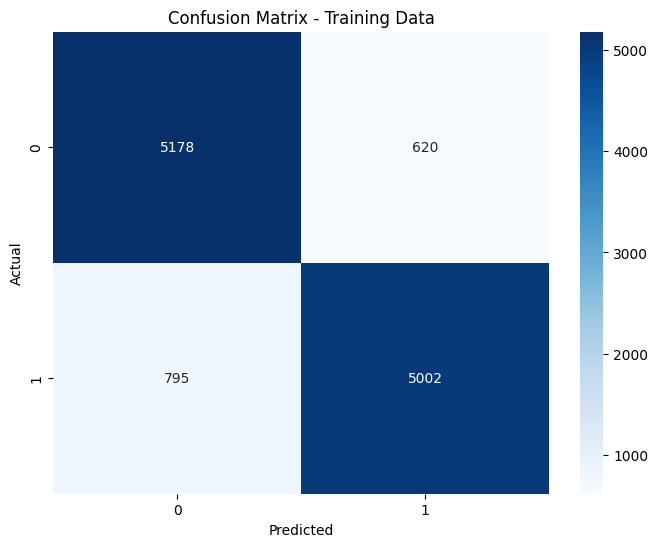

In [59]:
# Plot confusion matrix for training data
train_cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Lightgbm on unbalanced data

In [60]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 32,
    'learning_rate': 0.01,
    'n_estimators': 150
}

# Initialize the LightGBM model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = lgb_model.predict(X_train_unbalanced)
y_train_pred_prob = lgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = lgb_model.predict(X_test_unbalanced)
y_test_pred_prob = lgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

[LightGBM] [Info] Number of positive: 370, number of negative: 5798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 6168, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059987 -> initscore=-2.751765
[LightGBM] [Info] Start training from score -2.751765
Training Metrics:
F1 Score: 0.06266318537859007
ROC AUC Score: 0.9394495305930284
Accuracy: 0.9417963683527886

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8212941434857356
Accuracy: 0.9416342412451362


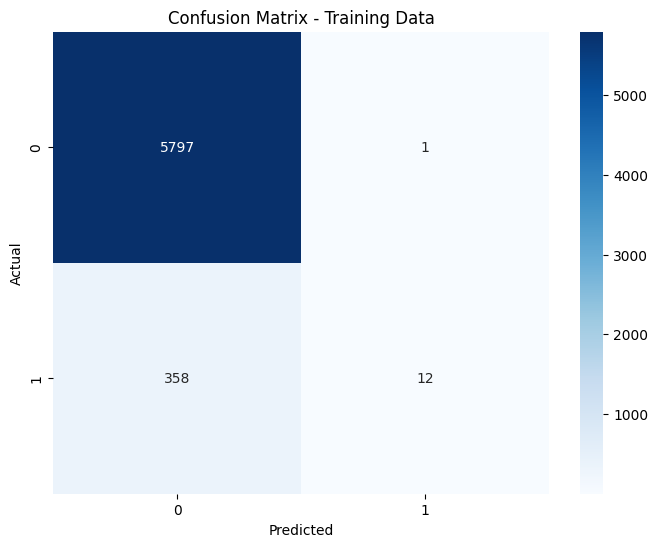

In [61]:
# Plot confusion matrix for training data
train_cm = confusion_matrix(y_train_unbalanced, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "LightGBM model training")

# Infer the model signature
signature = infer_signature(X_train, lgb_model.predict(X_train))

# Log the model
model_info = mlflow.lightgbm.log_model(
    lgb_model,
    artifact_path="insurance_fraud_model_lgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="LightGBM_v4",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'LightGBM_v4'.
2024/11/16 11:31:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_v4, version 1


# XGBoost on balanced data

In [ ]:
# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 100,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train)
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9138961366888309
ROC AUC Score: 0.9698114659227991
Accuracy: 0.9117723156532989

Test Metrics:
F1 Score: 0.17088607594936708
ROC AUC Score: 0.7465862875924902
Accuracy: 0.8300907911802854


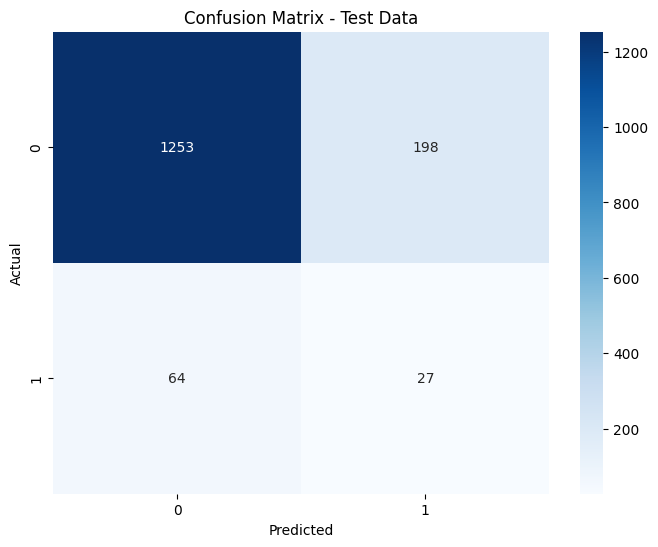

In [68]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Modeling with Optuna
 - Optuna is an advanced hyperparameter optimization framework designed to streamline the tuning process in machine learning. It employs a Bayesian optimization approach, focusing on efficiency and automation by sampling hyperparameters intelligently based on past results. Unlike traditional methods like GridSearch, which exhaustively evaluates all parameter combinations, Optuna uses a more flexible and adaptive approach with its define-by-run API. This allows it to explore the hyperparameter space dynamically, saving computation time and resources. Additionally, Optuna supports pruning, which terminates underperforming trials early to focus on promising ones. While GridSearch is simple and systematic, making it easier to implement for smaller datasets or straightforward models, Optuna is more suitable for complex problems with large search spaces, where efficiency and scalability are crucial.

## Optuna framework on unbalanced data with boosting models

In [33]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 30, 200)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators)
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 30, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 100, 200)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.2)
        depth = trial.suggest_int('cat_depth', 3, 9)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
    classifier_obj.fit(X_train_unbalanced, y_train_unbalanced)
    y_prob = classifier_obj.predict_proba(X_test_unbalanced)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test_unbalanced, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [50]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=150)

[I 2024-11-21 22:42:02,983] A new study created in memory with name: no-name-0d6dd20f-38c0-49ca-b1d3-93a5e3dccd87
[I 2024-11-21 22:42:03,864] Trial 0 finished with value: 0.6930763929385569 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 120, 'cat_learning_rate': 0.06723018869573985, 'cat_depth': 4}. Best is trial 0 with value: 0.6930763929385569.
[I 2024-11-21 22:42:05,321] Trial 1 finished with value: 0.5689217742973773 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 152, 'cat_learning_rate': 0.11145906935695746, 'cat_depth': 9}. Best is trial 0 with value: 0.6930763929385569.
[I 2024-11-21 22:42:05,749] Trial 2 finished with value: 0.7195340841102386 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.017888566510002653, 'max_depth': 4, 'n_estimators': 74}. Best is trial 2 with value: 0.7195340841102386.
[I 2024-11-21 22:42:06,839] Trial 3 finished with value: 0.6237910951901303 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.105144848

In [51]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.7694844783059807]
Best hyperparameters:  {'classifier': 'XGBoost', 'learning_rate': 0.06566152791564024, 'max_depth': 4, 'n_estimators': 73}


In [52]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.06566152791564024,
    'max_depth': 4,
    'n_estimators': 73,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train_unbalanced, y_train_unbalanced)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train_unbalanced)
y_train_pred_prob = xgb_model.predict_proba(X_train_unbalanced)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test_unbalanced)
y_test_pred_prob = xgb_model.predict_proba(X_test_unbalanced)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train_unbalanced, y_train_pred)
train_roc_auc = roc_auc_score(y_train_unbalanced, y_train_pred_prob)
train_accuracy = accuracy_score(y_train_unbalanced, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test_unbalanced, y_test_pred)
test_roc_auc = roc_auc_score(y_test_unbalanced, y_test_pred_prob)
test_accuracy = accuracy_score(y_test_unbalanced, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.08762886597938144
ROC AUC Score: 0.8636773631168251
Accuracy: 0.9426070038910506

Test Metrics:
F1 Score: 0.021739130434782608
ROC AUC Score: 0.8337751153050946
Accuracy: 0.9416342412451362


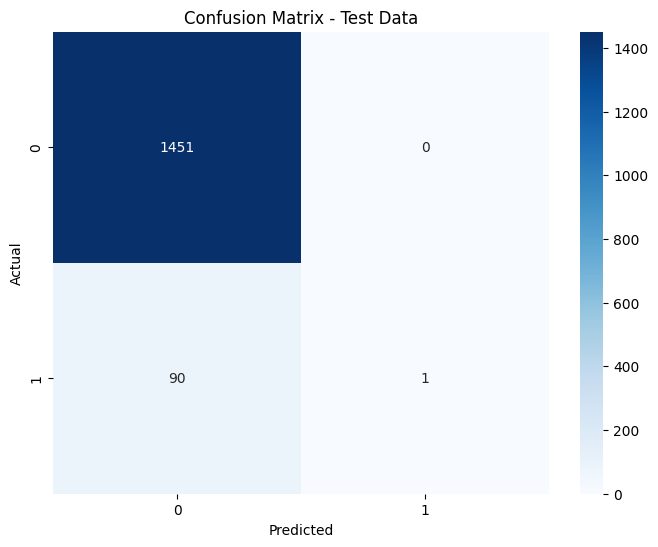

In [53]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test_unbalanced, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optuna with balanced data on boosting models

In [54]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LightGBM', 'CatBoost'])
    
    if classifier_name == 'XGBoost':
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        classifier_obj = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=42
        )
    
    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 30, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, verbose=-1)
    
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 100, 200)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.2)
        depth = trial.suggest_int('cat_depth', 3, 9)
        classifier_obj = CatBoostClassifier(iterations=iterations, depth=depth, verbose=0)
    
    classifier_obj.fit(X_train, y_train)
    y_prob = classifier_obj.predict_proba(X_test)[:, 1]
    
    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [79]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-11-22 00:07:53,174] A new study created in memory with name: no-name-b1d7dae5-1e57-47a7-911d-7bef0a83ac4a
[I 2024-11-22 00:07:58,537] Trial 0 finished with value: 0.6461553608348921 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 187, 'cat_learning_rate': 0.19402279903112396, 'cat_depth': 7}. Best is trial 0 with value: 0.6461553608348921.
[I 2024-11-22 00:07:59,067] Trial 1 finished with value: 0.7200755825841973 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.12790566917719876, 'max_depth': 4, 'n_estimators': 100}. Best is trial 1 with value: 0.7200755825841973.
[I 2024-11-22 00:08:02,696] Trial 2 finished with value: 0.6919706757749486 and parameters: {'classifier': 'CatBoost', 'cat_iterations': 167, 'cat_learning_rate': 0.13226526051367618, 'cat_depth': 4}. Best is trial 1 with value: 0.7200755825841973.
[I 2024-11-22 00:08:03,864] Trial 3 finished with value: 0.6171113517770995 and parameters: {'classifier': 'XGBoost', 'learning_rate': 0.125892798

In [80]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

Best trial:  [0.7526222915609546]
Best hyperparameters:  {'classifier': 'XGBoost', 'learning_rate': 0.040566117474977396, 'max_depth': 8, 'n_estimators': 82}


In [77]:
# Create a new MLflow Experiment
mlflow.set_experiment("insurance-fraud-detection-experiment")

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.022033511850738794,
    'max_depth': 8,
    'n_estimators': 137,
}

# Initialize the XGBoost model with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = xgb_model.predict(X_train)
y_train_pred_prob = xgb_model.predict_proba(X_train)[:, 1]

# Make predictions on test data
y_test_pred = xgb_model.predict(X_test)
y_test_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model on training data
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on test data
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Metrics:")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")
print(f"Accuracy: {train_accuracy}")

print("\nTest Metrics:")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")
print(f"Accuracy: {test_accuracy}")

Training Metrics:
F1 Score: 0.9251677852348993
ROC AUC Score: 0.974547444369859
Accuracy: 0.9230702889176369

Test Metrics:
F1 Score: 0.15337423312883436
ROC AUC Score: 0.746737755697094
Accuracy: 0.8210116731517509


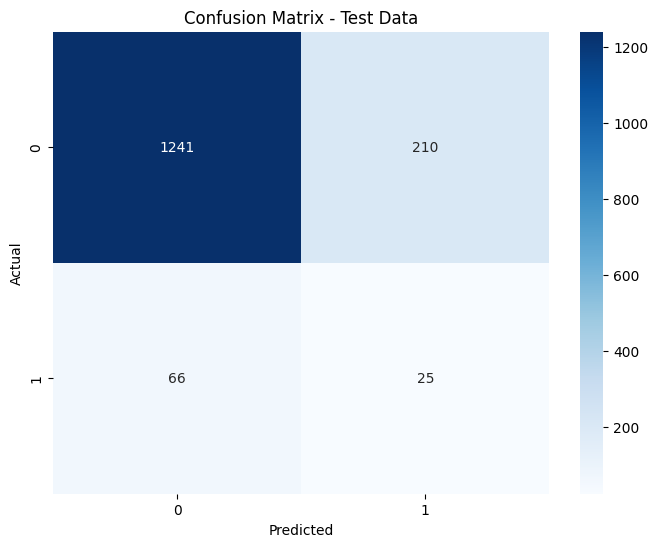

In [78]:
# Plot confusion matrix for test data
train_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
# Log parameters and metrics with MLflow
mlflow.log_params(params)
mlflow.log_metric("train_accuracy", train_accuracy)
mlflow.log_metric("train_F1 Score", train_f1)
mlflow.log_metric("train_ROC AUC Score", train_roc_auc)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_F1 Score", test_f1)
mlflow.log_metric("test_ROC AUC Score", test_roc_auc)

# Set a tag for the run
mlflow.set_tag("Training Info", "XGBoost model training")

# Infer the model signature
signature = infer_signature(X_train, xgb_model.predict(X_train))

# Log the model
model_info = mlflow.xgboost.log_model(
    xgb_model,
    artifact_path="insurance_fraud_model_xgb",
    signature=signature,
    input_example=X_train,
    registered_model_name="XGBoost_optuna",
)

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b